## 로지스틱 회귀

- 선형 회귀 방식을 분류에 적용한 알고리즘
- 시그모이드 함수 최적선을 찾고, 반환값을 확률로 간주해 확률에 따라 분류를 결정
- 사이킷런의 LogisticRegression 클래스

In [1]:
# 위스콘신 유방암 데이터 세트 기반 로지스틱 회귀로 암 여부 판단
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [2]:
# 선형 회귀 계열의 로지스틱 회귀는 데이터의 정규 분포도에 따라 예측 성능 영향
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

# 데이터 세트 분리
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver = 'lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# accuracy, roc_auc 측정
print('Accuracy : {0:.3f}, ROC-AUC : {1:.3f}'.format(accuracy_score(y_test, pred), 
                                                    roc_auc_score(y_test, pred)))

Accuracy : 0.977, ROC-AUC : 0.972


In [4]:
# 서로 다른 solver 값 성능 비교
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값 별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver = solver, max_iter = 600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)

    # accuracy, roc_auc 측정
    print('Solver : {0}, Accuracy : {1:.3f}, ROC-AUC : {2:.3f}'.format(solver, 
                                                                       accuracy_score(y_test, lr_preds), 
                                                                       roc_auc_score(y_test, lr_preds)))

Solver : lbfgs, Accuracy : 0.977, ROC-AUC : 0.972
Solver : liblinear, Accuracy : 0.982, ROC-AUC : 0.979
Solver : newton-cg, Accuracy : 0.977, ROC-AUC : 0.972
Solver : sag, Accuracy : 0.982, ROC-AUC : 0.979
Solver : saga, Accuracy : 0.982, ROC-AUC : 0.979


#### liblinear, sag, saga가 상대적으로 높지만 데이터 세트가 워낙 작기에 의미있는 결과는 아님.

- LogisticRegression의 주요 하이퍼 파라미터 : penalty, C
- penalty : 규제의 유형. 'l2'로 설정 시 L2 규제, 'l1'으로 설정 시 L1 규제, 기본은 'l2'
- C : 규제 강도를 조절하는 alpha 값의 역수. C값이 작을수록 규제 강도 큼.
- liblinear, saga의 경우 L1, L2 규제 모두 가능, 이 외의 solver는 L2 규제만 가능

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'solver' : ['liblinear', 'lbfgs'],
    'penalty' : ['l2', 'l1'],
    'C' : [0.01, 0.1, 1, 5, 10]
}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)

print('최적 하이퍼 파라미터 {0}, 최적 평균 정확도 : {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도 : 0.979


C:\Users\junki\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\junki\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\junki\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\junki\anaconda3\Lib\site-packages\sklearn\linear_model\_lo

#### solver가 lbfgs일 때 L1 규제를 지원하지 않음에도 L1 규제를 시도했기 때문에 나오는 오류

## 회귀 트리
- 결정 트리를 기반으로 하는 회귀 방식
- 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 모든 트리 기반의 알고리즘은 회귀도 가능

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# boston 데이터 세트 로드 (윤리적인 문제로 1.2 버전부터 삭제됨.)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns = feature_names)

bostonDF['PRICE'] = target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

rf = RandomForestRegressor(random_state=0, n_estimators = 1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423 


In [7]:
# 결정 트리, GBM, XGBoost, LightGBM의 Regressor를 이용해 보스턴 주택 가격 예측
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ', model.__class__.__name__, ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.251 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


<Axes: >

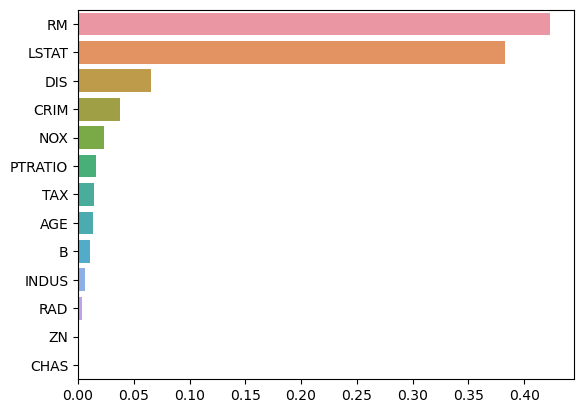

In [9]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index)

(100, 2)


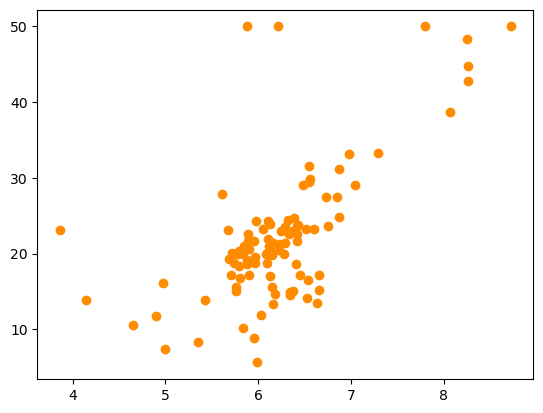

In [10]:
# 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n = 100, random_state = 0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5 ~ 8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

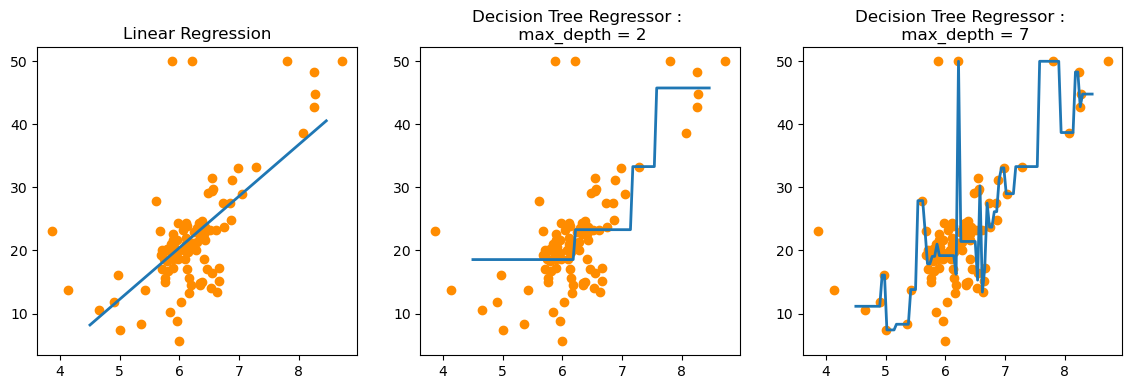

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14, 4), ncols = 3)

# X축 값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax1.plot(X_test, pred_lr, label = 'linear', linewidth = 2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regressor : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax2.plot(X_test, pred_rf2, label = 'max_depth:3', linewidth = 2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regressor : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax3.plot(X_test, pred_rf7, label = 'max_depth:7', linewidth = 2)

- 선형 회귀는 직선으로 예측 회귀선을 표현하는 데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선 만듦.
- 이상치도 학습하면서 복잡한 형태의 회귀선. 과적합 되기 쉬움.